In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from tqdm import tqdm

# Models
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklego.mixture import BayesianGMMClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

In [3]:
data = pd.read_csv("./data/data.csv", index_col="id")
sample_submission = pd.read_csv("./data/sample_submission.csv", index_col="Id")

# Data First Look

In [4]:
data.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
id,,,,,,,,,,,,,,,,,,,,,
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [5]:
# Missing values and data types check 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98000 entries, 0 to 97999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_00    98000 non-null  float64
 1   f_01    98000 non-null  float64
 2   f_02    98000 non-null  float64
 3   f_03    98000 non-null  float64
 4   f_04    98000 non-null  float64
 5   f_05    98000 non-null  float64
 6   f_06    98000 non-null  float64
 7   f_07    98000 non-null  int64  
 8   f_08    98000 non-null  int64  
 9   f_09    98000 non-null  int64  
 10  f_10    98000 non-null  int64  
 11  f_11    98000 non-null  int64  
 12  f_12    98000 non-null  int64  
 13  f_13    98000 non-null  int64  
 14  f_14    98000 non-null  float64
 15  f_15    98000 non-null  float64
 16  f_16    98000 non-null  float64
 17  f_17    98000 non-null  float64
 18  f_18    98000 non-null  float64
 19  f_19    98000 non-null  float64
 20  f_20    98000 non-null  float64
 21  f_21    98000 non-null  float64
 22

In [6]:
# Duplicates check
data.duplicated().sum()

0

### First Look Results
* No missing data
* No duplicates
* Features f_07 to f_13 are integers and other are floats 

# Express Data Analysis
## Data Visaulization

In [7]:
int_cols = data.select_dtypes(include=["int64"]).columns.tolist()
float_cols = data.select_dtypes(include=["float64"]).columns.tolist()

### Integer Features

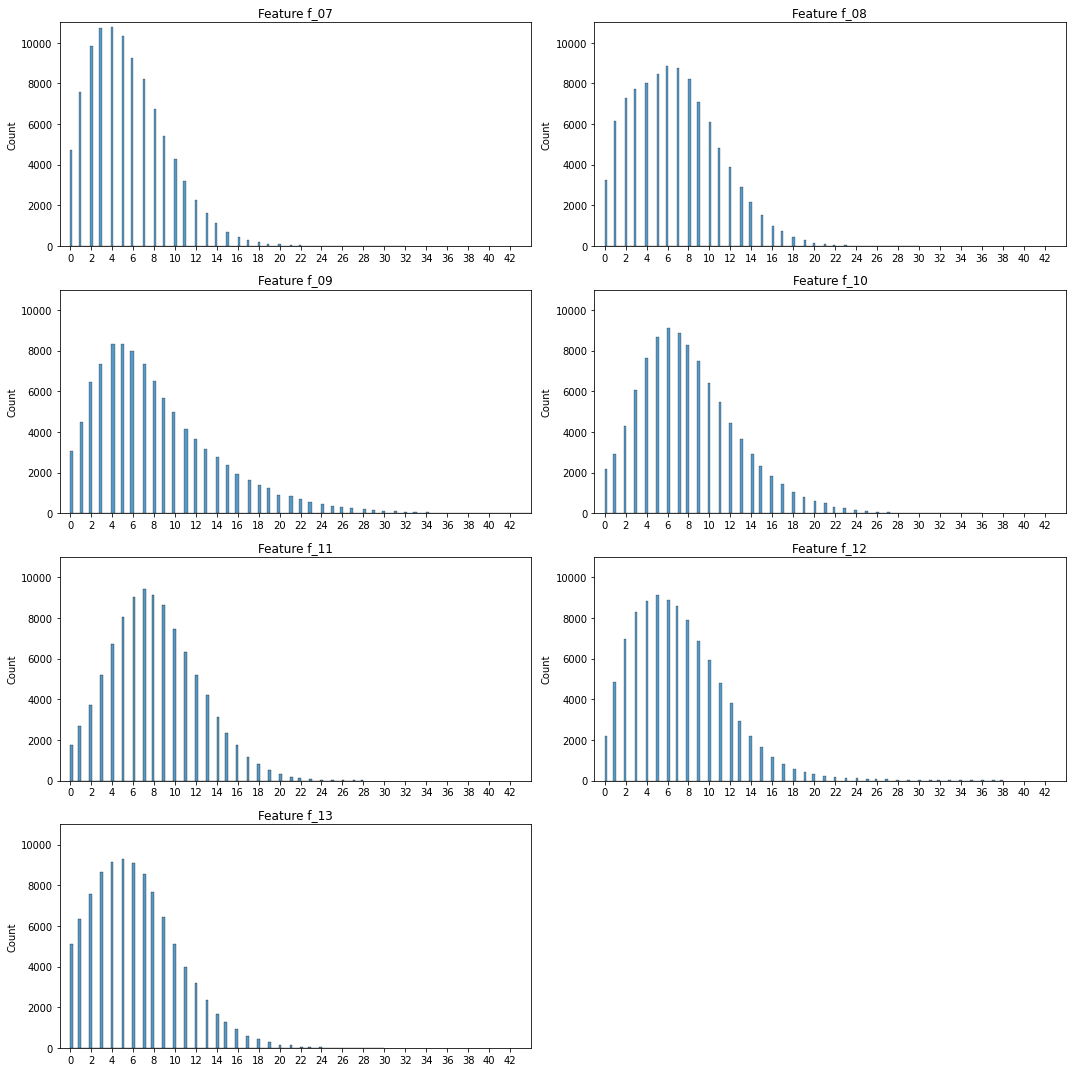

In [8]:
fig = plt.figure(figsize=(15, 15))
position = 1
c_num = 2

for col in int_cols:
    plt.subplot(len(int_cols) // c_num + (len(int_cols) % c_num), c_num, position)
    sns.histplot(x=data.loc[:, col])
    position += 1
    
    plt.title(f"Feature {col}")
    plt.xlim([-1, 44]) 
    plt.ylim([0, 11000])
    plt.xticks(np.arange(0, 44, 2))
    plt.xlabel('')
    
    
fig.tight_layout()    
plt.show()

### Float Features

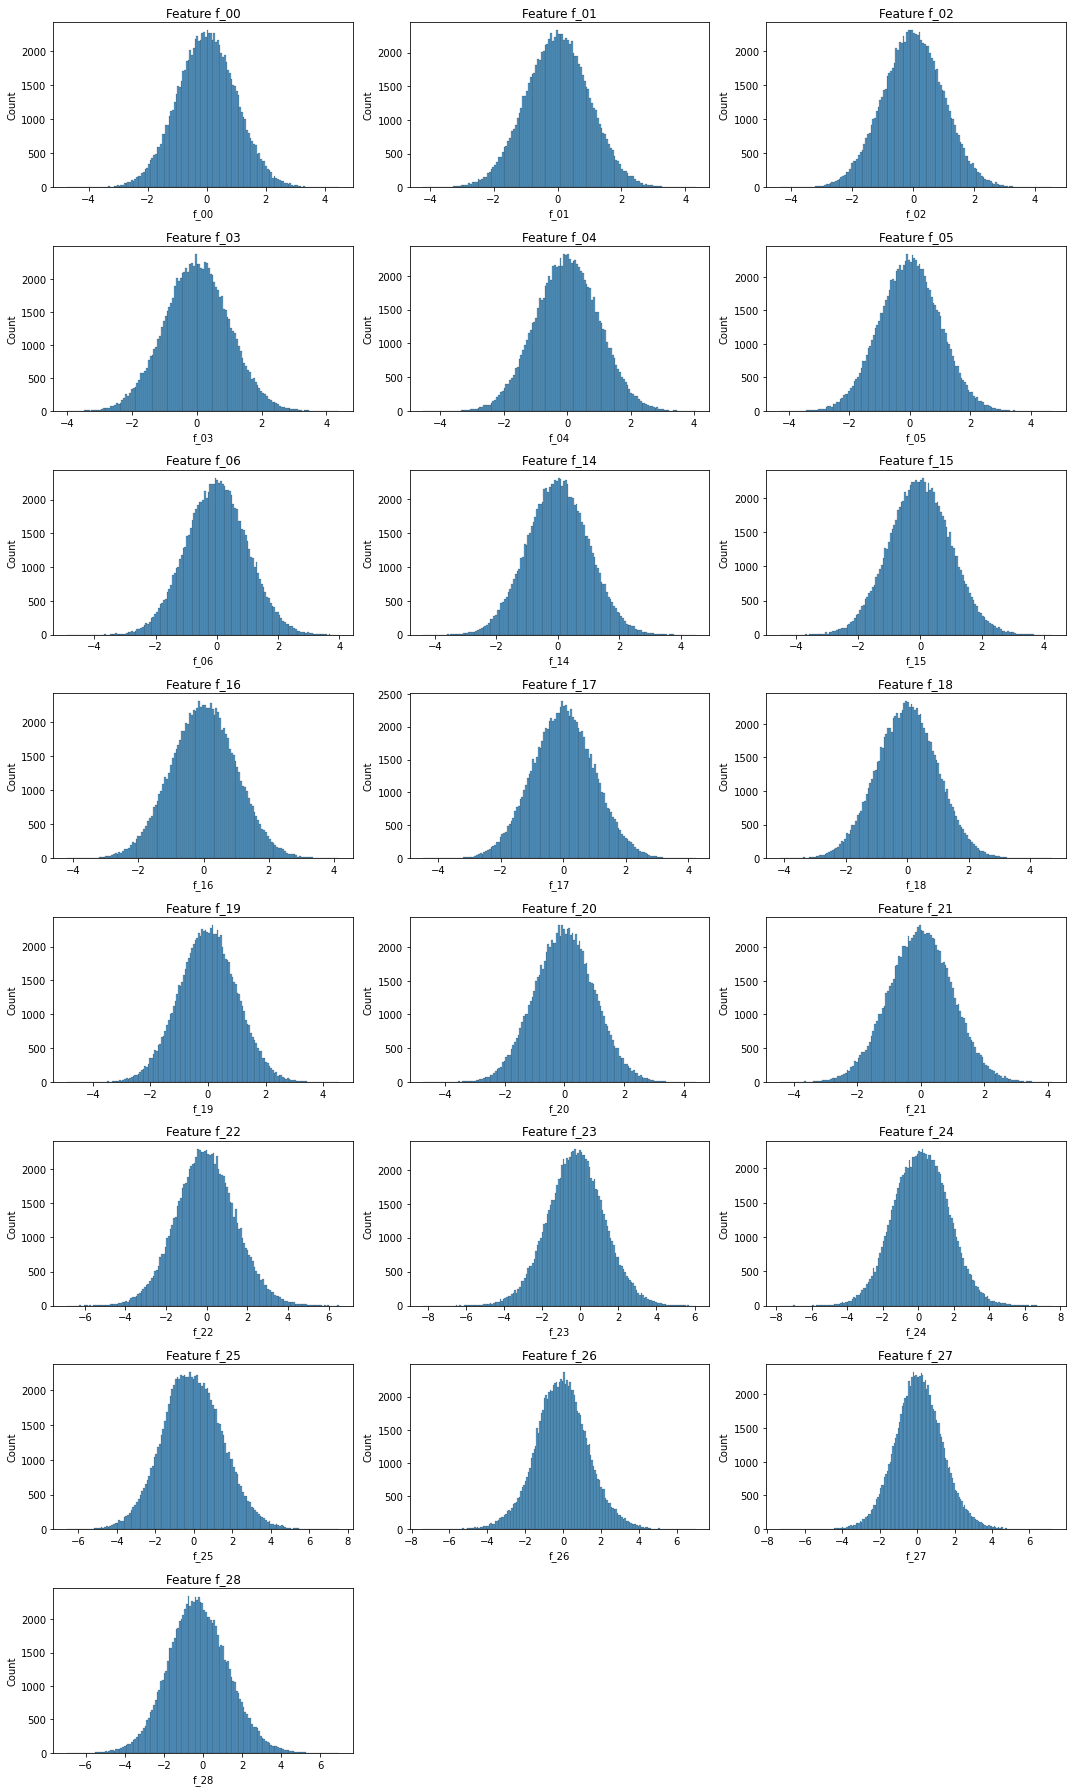

In [9]:
fig = plt.figure(figsize=(15, 25))
position = 1
c_num = 3

for col in float_cols:
    plt.subplot(len(float_cols) // c_num + (len(float_cols) % c_num), c_num, position)
    sns.histplot(x=data.loc[:, col])
    position += 1
    
    plt.title(f"Feature {col}")
    
fig.tight_layout()    
plt.show()

### Data Correlation

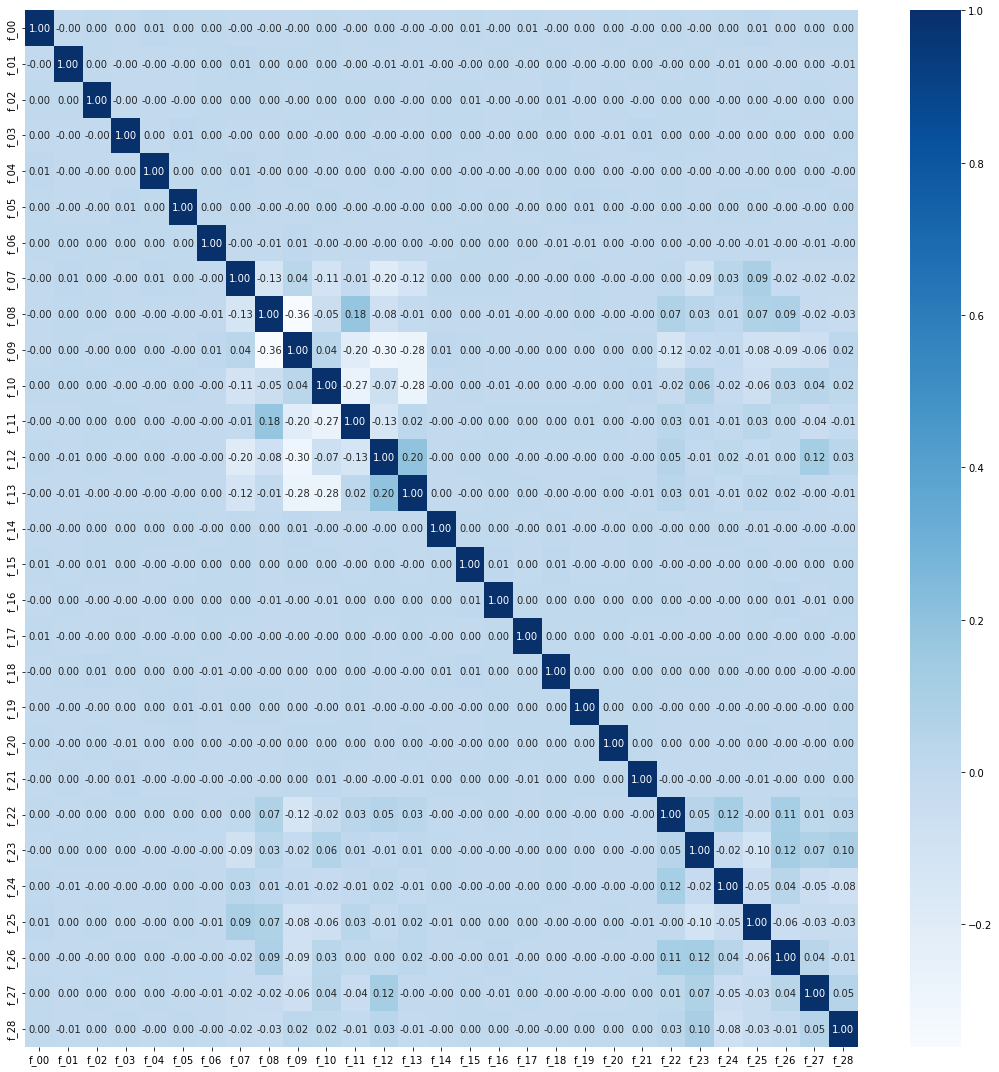

In [10]:
fig = plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), cmap="Blues", annot=True, fmt='0.2f')
fig.tight_layout()
plt.show()

### Express Analysis Results
* Integer features are skewed right, and don't have negative values
* Float point features are close to normally distributed 
* Features f_07 to f_13 and f_22 to f_28 have a very weak correlation crossings, but still we have to keep it in mind

We need to scale the data, because of the values differences, to make clusterization process more effective.  

**In addition:** 
* You can use *Shapiro-Wilk Test* to test whether a dataset is distributed normally or not (from scipy.stats import shapiro).
* Make a *Poisson Dispertion Test* for the integer features.

# Preprocessing
Power transformer fits the best.

In [11]:
transformer = PowerTransformer()
scaled_data = transformer.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns = data.columns)

# Optimal Number of Clusters
I usually use Elbow Method with KMeans to find optimal clusters number, but I will provide another approach using **Gaussian Mixture Model** like in [CABAXIOMs notebook](https://www.kaggle.com/code/cabaxiom/tps-jul-22-bgmm-semi-supervised?scriptVersionId=101585342&cellId=11), because in this case KMeans is not very good.

## Elbow Method

In [12]:
inertias = []
for n in tqdm(range(1, 16)):  # number of clusters (from 1 to 15)
    km = KMeans(n_clusters=n)
    km.fit(scaled_data)
    inertias.append(km.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:49<00:00,  3.27s/it]


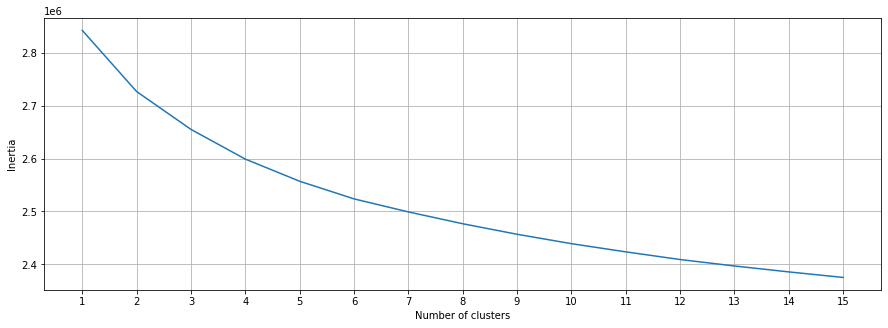

In [13]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=range(1, len(inertias) + 1), y=inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.xticks(range(1, 16))

plt.show()

## Gaussian Mixture Model
It will take a while (3h 20m on my PC), but you will see the big difference.

In [14]:
# bic_scores = []
# for n in tqdm(range(1, 16)):
#     bic_scores_n = []
#     for seed in range(10):
#         gmm = GaussianMixture(n_components=n, covariance_type="full", n_init=3, random_state=seed)
#         gmm.fit(scaled_data)
#         bic_scores_n.append(gmm.bic(scaled_data))
#     bic_scores.append(bic_scores_n)

In [15]:
# plt.figure(figsize=(15, 5))
# for i in range(10):
#     sns.lineplot(x=range(1, 16), y=np.array(bic_scores)[:, i])
    
# plt.xlabel('Number of clusters')
# plt.ylabel('Bayesian Information Criterion')
# plt.grid()
# plt.xticks(range(1, 16))

# plt.show()

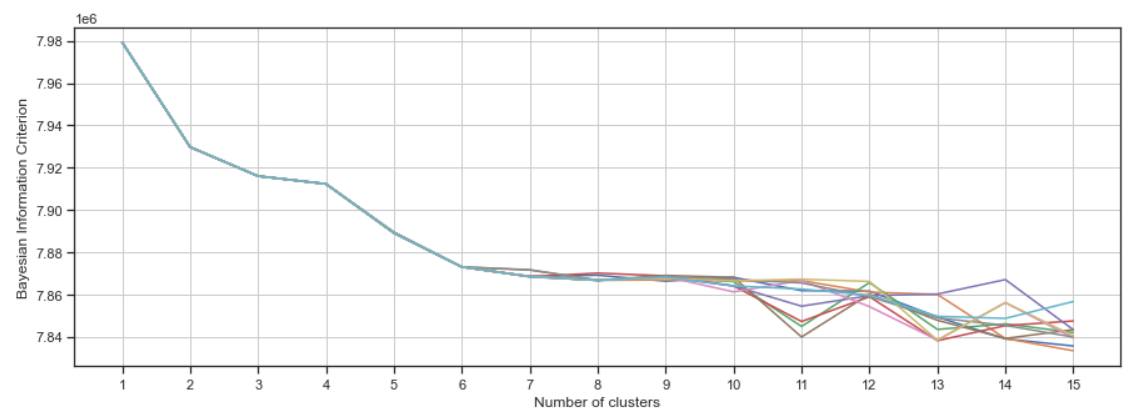

### Optimal Number of Clusters Results
* There is no obvious decision. We can use 6, 7 or 8 clusters. Let's take the middle one.

# Feature Importance
We can use Bayesian Gaussian Mixture Model (this model shows the best results) to understand feature importance in our dataset. It can help us to cut off useless data and get a training speed improvement. Technique from [SAMUEL CORTINHAS notebook](https://www.kaggle.com/code/samuelcortinhas/tps-july-22-unsupervised-clustering?scriptVersionId=101121043&cellId=31).   

In [16]:
bgmm = BayesianGaussianMixture(n_components=7, covariance_type="full", n_init=3, random_state=0)
predictions = bgmm.fit_predict(scaled_data)

We should plot the position of the center of each cluster to visualise how well each feature is able to separate the different clusters.

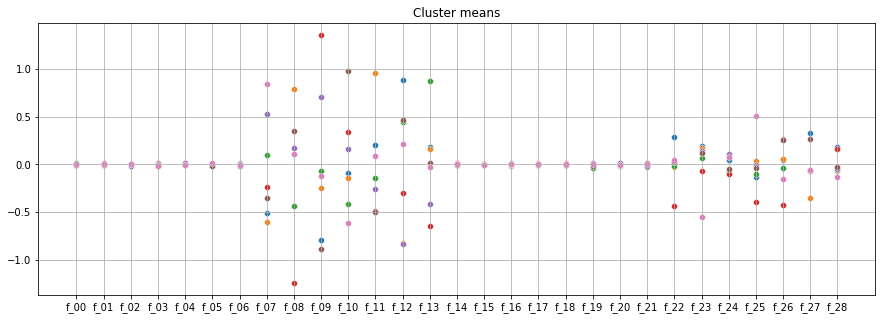

In [17]:
plt.figure(figsize=(15, 5))
for i in range(bgmm.means_.shape[0]):
    sns.scatterplot(x=range(len(scaled_data.columns)), y=bgmm.means_[i])

plt.xticks(ticks=range(len(scaled_data.columns)), labels=scaled_data.columns)
plt.title("Cluster means")
plt.grid()
plt.show()

### Feature Importance Results
* Now we see that features f_00 to f_06 and f_14 to f_21 have almost similar means. Which leads us to a thought that they don't affect the division on clusters.

# Clusterization

In [18]:
# Based on Feature Importance part, let's take only useful features
best_int_columns = ["f_07", "f_08", "f_09", "f_10", "f_11", "f_12", "f_13"]
best_float_columns = ["f_22", "f_23", "f_24", "f_25", "f_26", "f_27", "f_28"]
best_columns = best_int_columns + best_float_columns

Next I will use approaches from [CABAXIOMs notebook](https://www.kaggle.com/code/cabaxiom/tps-jul-22-bgmm-semi-supervised?scriptVersionId=101585342&cellId=29) to score the models and to build soft voting mechanism. Soft voting mechanism needed because each time cluster centers are randomly initialized, and this can have a big impact on the results.

In [19]:
def score_clusters(X: np.array, predictions: np.array, silhouette: bool=True, verbose: bool=False) -> tuple:
    """Evaluate how good our cluster label predictions are"""
    
    db_score = davies_bouldin_score(X=X, labels=predictions)
    ch_score = calinski_harabasz_score(X=X, labels=predictions)
    s_score = silhouette_score(X=X, labels=predictions, metric="euclidean")
    
    if verbose:
        print("David Bouldin score: {0:0.4f}".format(db_score))
        print("Calinski Harabasz score: {0:0.3f}".format(ch_score))
        print("Silhouette score: {0:0.4f}".format(s_score))
        
    return db_score, ch_score, s_score

In [20]:
def soft_voting(predict_number: int, best_cols: list=best_columns) -> np.array:
    """Concatenate multiple results of BGMM with different starting points"""
    
    predicted_probabilities = pd.DataFrame(np.zeros((len(data),7)), columns=range(1,8))  # dataframe with zeros
    
    # loop with a different random seeds
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = scaled_data.sample(40000)
        gmm = BayesianGaussianMixture(n_components=7, 
                                      covariance_type="full", 
                                      max_iter=300, 
                                      init_params="kmeans", 
                                      n_init=3, 
                                      random_state=i)
        gmm.fit(X_scaled_sample[best_cols])
        pred_probs = gmm.predict_proba(scaled_data[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # Ensuring clusters are labeled the same value at each fit
        if i == 0:
            initial_centers = gmm.means_
            
        new_classes = []
        for mean2 in gmm.means_:
            # For the current center of the current gmm, find the distances to every center in the initial gmm
            distances = [np.linalg.norm(mean1-mean2) for mean1 in initial_centers]
            
            # Select the class with the minimum distance
            new_class = np.argmin(distances) + 1 # Add 1 as our labels are 1-7 but index is 0-6
            new_classes.append(new_class)
            
        # If the mapping from old cluster labels to new cluster labels isn't 1 to 1
        if len(new_classes) != len(set(new_classes)):
            print("Iteration", i, "could not determine the cluster label mapping, skipping")
            continue
            
        # Apply the mapping by renaming the dataframe columns representing the original labels to the new labels    
        pred_probs = pred_probs.rename(columns=dict(zip(range(1, 8), new_classes)))
        
        # Add the current prediction probabilities to the overall prediction probabilities
        predicted_probabilities = predicted_probabilities + pred_probs
        
        # Let's score the cluster labels each iteration to see if soft voting is helpful
        score_clusters(scaled_data[best_cols], predicted_probabilities.idxmax(axis=1), verbose=True)
    
    # Normalise dataframe so each row sums to 1
    predicted_probabilities = predicted_probabilities.div(predicted_probabilities.sum(axis=1), axis=0)
    return predicted_probabilities

In [21]:
predictions = soft_voting(10)
print("\nBest variant:")
score_clusters(scaled_data[best_columns], predictions.idxmax(axis=1), verbose=True)  # best variant scores

========= 0 ==========
David Bouldin score: 3.7496
Calinski Harabasz score: 3872.469
Silhouette score: 0.0387
========= 1 ==========
David Bouldin score: 3.6713
Calinski Harabasz score: 3827.726
Silhouette score: 0.0371
========= 2 ==========
David Bouldin score: 3.6490
Calinski Harabasz score: 3804.439
Silhouette score: 0.0362
========= 3 ==========
David Bouldin score: 3.6434
Calinski Harabasz score: 3804.762
Silhouette score: 0.0361
========= 4 ==========
David Bouldin score: 3.6521
Calinski Harabasz score: 3807.982
Silhouette score: 0.0363
========= 5 ==========
David Bouldin score: 3.6446
Calinski Harabasz score: 3807.063
Silhouette score: 0.0362
========= 6 ==========
David Bouldin score: 3.6410
Calinski Harabasz score: 3806.167
Silhouette score: 0.0360
========= 7 ==========
David Bouldin score: 3.6380
Calinski Harabasz score: 3805.852
Silhouette score: 0.0360
========= 8 ==========
Iteration 8 could not determine the cluster label mapping, skipping
========= 9 ==========
David 

(3.636114412279979, 3807.2381463914708, 0.035946237498473824)

In [22]:
def best_class(df: pd.DataFrame) -> pd.DataFrame: 
    new_df = df.copy()
    new_df["highest_prob"] = df.max(axis=1)
    new_df["best_class"] = df.idxmax(axis=1)
    new_df["second_highest_prob"] = df.apply(lambda x: x.nlargest(2).values[-1], axis=1)
    new_df["second_best_class"] = df.apply(lambda x: np.where(x == x.nlargest(2).values[-1])[0][0] + 1, axis=1)
    return new_df

In [23]:
best_predictions = best_class(predictions)
best_predictions.head()

,1,2,3,4,5,6,7,highest_prob,best_class,second_highest_prob,second_best_class
0,3.761962e-07,0.002724,0.012005,0.000487,0.976976,0.004101,0.003706,0.976976,5,0.012005,3
1,1.154852e-02,0.024558,0.941430,0.003876,0.000349,0.000014,0.018225,0.941430,3,0.024558,2
2,8.304216e-09,0.000015,0.000380,0.001721,0.817417,0.180360,0.000107,0.817417,5,0.180360,6
3,8.395965e-01,0.011654,0.016731,0.029594,0.000018,0.102357,0.000050,0.839596,1,0.102357,6
4,7.674137e-07,0.000004,0.018013,0.981791,0.000005,0.000015,0.000170,0.981791,4,0.018013,3


Let's visualise how confident our predictions are:

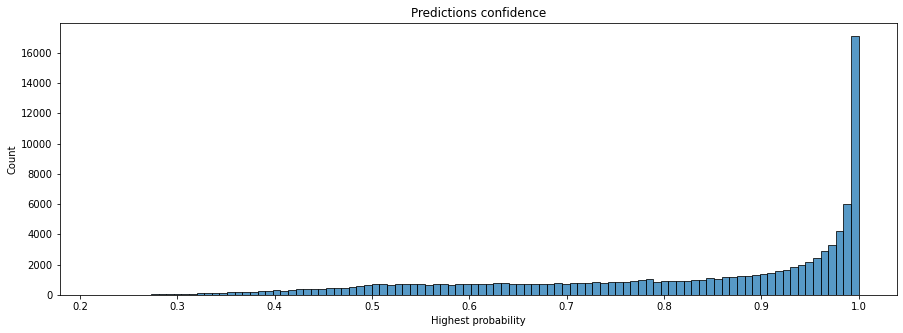

In [24]:
plt.figure(figsize=(15, 5))
sns.histplot(best_predictions["highest_prob"], bins=100)
plt.xlabel("Highest probability")
plt.title("Predictions confidence")
plt.show()

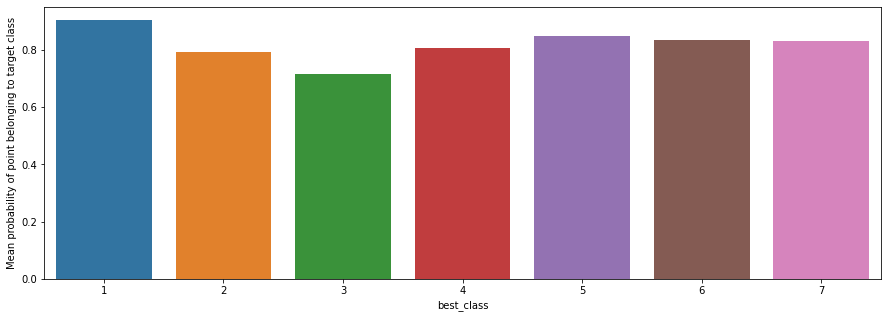

In [25]:
confidence_s = best_predictions.groupby("best_class")["highest_prob"].mean()
plt.figure(figsize=(15, 5))
sns.barplot(x=confidence_s.index, y=confidence_s.values)
plt.ylabel("Mean probability of point belonging to target class")
plt.show()

# Classification
The main idea is to take points the clustering algorithm is confident with and train a classification model to predict the points it is not confident with.

## Prepair Dataset

In [26]:
# We take only clusters with confidence percent is greater or equal to 85
confident_predictions = best_predictions.loc[best_predictions["highest_prob"] >= 0.85]
confident_predictions_class = confident_predictions["best_class"]
scaled_data["class"] = confident_predictions_class 

train_df = scaled_data.loc[scaled_data["class"] == scaled_data["class"]]
test_df = scaled_data.loc[scaled_data["class"] != scaled_data["class"]]

print("Train df shape:", train_df.shape)
print("Test df shape:", test_df.shape)

Train df shape: (55274, 30)
Test df shape: (42726, 30)


In [27]:
X = train_df.drop(columns="class").reset_index(drop=True)
y = train_df["class"].reset_index(drop=True)
X_test = test_df.drop(columns="class").reset_index(drop=True)
X_full = scaled_data.drop(columns="class")

## Cross Validation
### Define Models

In [28]:
# Set random statet
rs = 1
n_cores = -1

etc = ExtraTreesClassifier(
    n_estimators=2000, 
    random_state=rs,
    n_jobs=n_cores)

qda = QuadraticDiscriminantAnalysis()

lda = LinearDiscriminantAnalysis()

bgmm = BayesianGMMClassifier(
    n_components=7,
    tol=0.001,
    covariance_type="full",
    max_iter=400,
    n_init=4,
    init_params="kmeans",
    random_state=rs)

log_reg = LogisticRegression(
    C=1.0, 
    solver="lbfgs", 
    max_iter=300,
    random_state=rs,
    n_jobs=n_cores)

svc = SVC(
    C=10.0, 
    gamma=0.0001,
    probability=True, 
    random_state=rs)

knn = KNeighborsClassifier(
    n_neighbors=7, 
    leaf_size=20,
    n_jobs=n_cores)

dtc = DecisionTreeClassifier(
    max_depth=5, 
    random_state=rs)

r_forest = RandomForestClassifier(
    n_estimators=2000, 
    max_depth=5, 
    random_state=rs,
    n_jobs=n_cores)

lg_boost = LGBMClassifier(
    objective = 'multiclass',
    num_leaves=30,
    max_depth=3,
    learning_rate=0.05,
    n_estimators=2000,
    max_bin=250,
    feature_fraction_seed=rs,
    bagging_seed=rs,
    n_jobs=n_cores)

models = [("etc", etc),
          ("qda", qda),
          ("lda", lda),
          ("bgmm", bgmm),
          ('log_reg', log_reg),
          ('svc', svc),
          ('knn', knn),
          ('dtc', dtc),
          ('r_forest', r_forest),
          ('lg_boost', lg_boost)]

 ### Estimate models

In [29]:
def k_fold_cv(X_: pd.DataFrame, y_: pd.DataFrame, model) -> tuple:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    y_pred_list, y_true_list = [], []
    
    for fold, (train_index, val_index) in enumerate(kfold.split(X_, y_)):
        X_train = X_.loc[train_index]
        X_val = X_.loc[val_index]

        y_train = y_.loc[train_index]
        y_val = y_.loc[val_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        y_pred_list = np.append(y_pred_list, y_pred)
        y_true_list = np.append(y_true_list, y_val)
        
    return y_pred_list, y_true_list

In [30]:
model_table = pd.DataFrame()
index = 0
for model_name, model in tqdm(models):
    model_table.loc[index, 'Name'] = model_name
    y_pred_list, y_true_list, = k_fold_cv(X[best_columns], y, model)
    model_table.loc[index, 'Accuracy'] = accuracy_score(y_pred_list, y_true_list)
    model_table.loc[index, 'F1_score_weighted'] = f1_score(y_pred_list, y_true_list, average="weighted")
    index += 1

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [23:12<00:00, 139.27s/it]


In [31]:
model_table

,Name,Accuracy,F1_score_weighted
0,etc,0.988078,0.988088
1,qda,1.000000,1.000000
2,lda,0.875258,0.875731
3,bgmm,0.991189,0.991190
4,log_reg,0.894345,0.894567
5,svc,0.917882,0.918227
6,knn,0.994048,0.994053
7,dtc,0.767974,0.784158
8,r_forest,0.875855,0.877865
9,lg_boost,0.996418,0.996418


# Inference

In [32]:
def fit_predict_all():
    predictions = []
    model_names = []
    scores = []
    
    for model_name, model in models:
        print("===", model_name, "===")
        model.fit(X[best_columns], y)
        preds_prob = model.predict_proba(X_full[best_columns])
        preds_prob_df = pd.DataFrame(preds_prob, columns=range(1,8), index=scaled_data.index)
        db, ch, s = score_clusters(scaled_data[best_columns], preds_prob_df.idxmax(axis=1), verbose=True)
        scores.append((db, ch, s))
        predictions.append(preds_prob_df)
        model_names.append(model_name)
        
    return predictions, model_names, scores

In [33]:
predictions, model_names, scores = fit_predict_all()

=== etc ===
David Bouldin score: 3.4300
Calinski Harabasz score: 4009.201
Silhouette score: 0.0426
=== qda ===
David Bouldin score: 3.5655
Calinski Harabasz score: 3937.790
Silhouette score: 0.0397
=== lda ===
David Bouldin score: 3.0886
Calinski Harabasz score: 4603.761
Silhouette score: 0.0558
=== bgmm ===
David Bouldin score: 3.6191
Calinski Harabasz score: 3844.571
Silhouette score: 0.0365
=== log_reg ===
David Bouldin score: 3.1955
Calinski Harabasz score: 4417.481
Silhouette score: 0.0496
=== svc ===
David Bouldin score: 3.1533
Calinski Harabasz score: 4444.174
Silhouette score: 0.0501
=== knn ===
David Bouldin score: 3.5108
Calinski Harabasz score: 3882.643
Silhouette score: 0.0399
=== dtc ===
David Bouldin score: 3.5216
Calinski Harabasz score: 3368.835
Silhouette score: 0.0286
=== r_forest ===
David Bouldin score: 3.2553
Calinski Harabasz score: 3891.599
Silhouette score: 0.0399
=== lg_boost ===
David Bouldin score: 3.5786
Calinski Harabasz score: 3904.839
Silhouette score: 0.

LDA has the best evaluation clustering score, but it has the worst leaderboard score.
## Combine Predictions
At this point we have 10 predictions from 10 different models.  
Now we need to combine all predictions in one.

In [135]:
predictions_df = 0.0 * predictions[0] \
+ 0.0 * predictions[1] \
+ 0.0 * predictions[2] \
+ 1.0 * predictions[3] \
+ 0.0 * predictions[4] \
+ 0.0 * predictions[5] \
+ 0.0 * predictions[6] \
+ 0.0 * predictions[7] \
+ 0.0 * predictions[8] \
+ 0.0 * predictions[9]

predictions_df

,1,2,3,4,5,6,7
0,2.861729e-11,1.189785e-06,1.973348e-06,2.510086e-08,9.996202e-01,3.370300e-04,3.961016e-05
1,1.244687e-04,3.833853e-06,9.996630e-01,2.310172e-07,1.435087e-08,4.560700e-11,2.084624e-04
2,6.895297e-16,1.617320e-09,9.829837e-08,4.360192e-06,3.721186e-01,6.278764e-01,6.020026e-07
3,9.976097e-01,6.795283e-05,1.298060e-05,9.657087e-05,2.579345e-09,2.212736e-03,5.355441e-08
4,3.777029e-11,4.582113e-08,1.997924e-04,9.998001e-01,1.205436e-12,1.096856e-10,1.044019e-07
...,...,...,...,...,...,...,...
97995,3.572956e-06,7.227369e-03,9.732358e-01,8.067940e-04,1.095047e-04,1.836703e-02,2.498927e-04
97996,1.415950e-16,9.784964e-01,1.909533e-05,2.135304e-02,2.364567e-06,1.488921e-09,1.290645e-04
97997,1.007025e-07,5.696075e-07,2.113893e-06,3.848996e-03,9.486653e-05,9.959984e-01,5.495657e-05
97998,3.755355e-04,1.178371e-03,6.789687e-04,1.647038e-09,5.045525e-07,7.497964e-04,9.970168e-01


**After playing with coefficients I made a decision - consider only BayesianGMMClassifier (solo it shows the best submission results, about 0.73)**

In [136]:
# Normalise 
predictions_df = predictions_df.div(predictions_df.sum(axis=1), axis=0)
predictions_df = best_class(predictions_df)

# Iterative Classification
To improve performance further we can iteratively use the predicted labels from the previous iteration's model as our training labels for the current iteration's model.

In [141]:
def update_predictions(predict_number, y):
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = scaled_data.sample(50000)
        y_sample = y.loc[X_scaled_sample.index]
        
        bgmmc = BayesianGMMClassifier(n_components=7,
                                      random_state=i,
                                      tol=0.001,
                                      covariance_type="full",
                                      max_iter=300,
                                      n_init=3,
                                      init_params="kmeans")
        
        bgmmc.fit(X_scaled_sample[best_columns], y_sample)
        
        pred_probs = bgmmc.predict_proba(scaled_data[best_columns])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # lets score the cluster labels each iteration
        score_clusters(scaled_data[best_columns], pred_probs.idxmax(axis=1), verbose=True)
        y = pred_probs.idxmax(axis=1)
        
    return pred_probs

In [147]:
predicted_probabilities = update_predictions(predict_number=25, y=predictions_df["best_class"])

========= 0 ==========
David Bouldin score: 3.8769
Calinski Harabasz score: 3539.505
Silhouette score: 0.0297
========= 1 ==========
David Bouldin score: 3.8826
Calinski Harabasz score: 3533.949
Silhouette score: 0.0295
========= 2 ==========
David Bouldin score: 3.8862
Calinski Harabasz score: 3538.651
Silhouette score: 0.0296
========= 3 ==========
David Bouldin score: 3.8803
Calinski Harabasz score: 3539.252
Silhouette score: 0.0296
========= 4 ==========
David Bouldin score: 3.8833
Calinski Harabasz score: 3539.283
Silhouette score: 0.0295
========= 5 ==========
David Bouldin score: 3.8779
Calinski Harabasz score: 3541.887
Silhouette score: 0.0296
========= 6 ==========
David Bouldin score: 3.8701
Calinski Harabasz score: 3541.301
Silhouette score: 0.0296
========= 7 ==========
David Bouldin score: 3.8755
Calinski Harabasz score: 3541.088
Silhouette score: 0.0296
========= 8 ==========
David Bouldin score: 3.8729
Calinski Harabasz score: 3542.084
Silhouette score: 0.0296
========= 

In [148]:
predictions_df = best_class(predicted_probabilities)

Now, for the interest, lets visualise which clusters are commonly confused with each other.

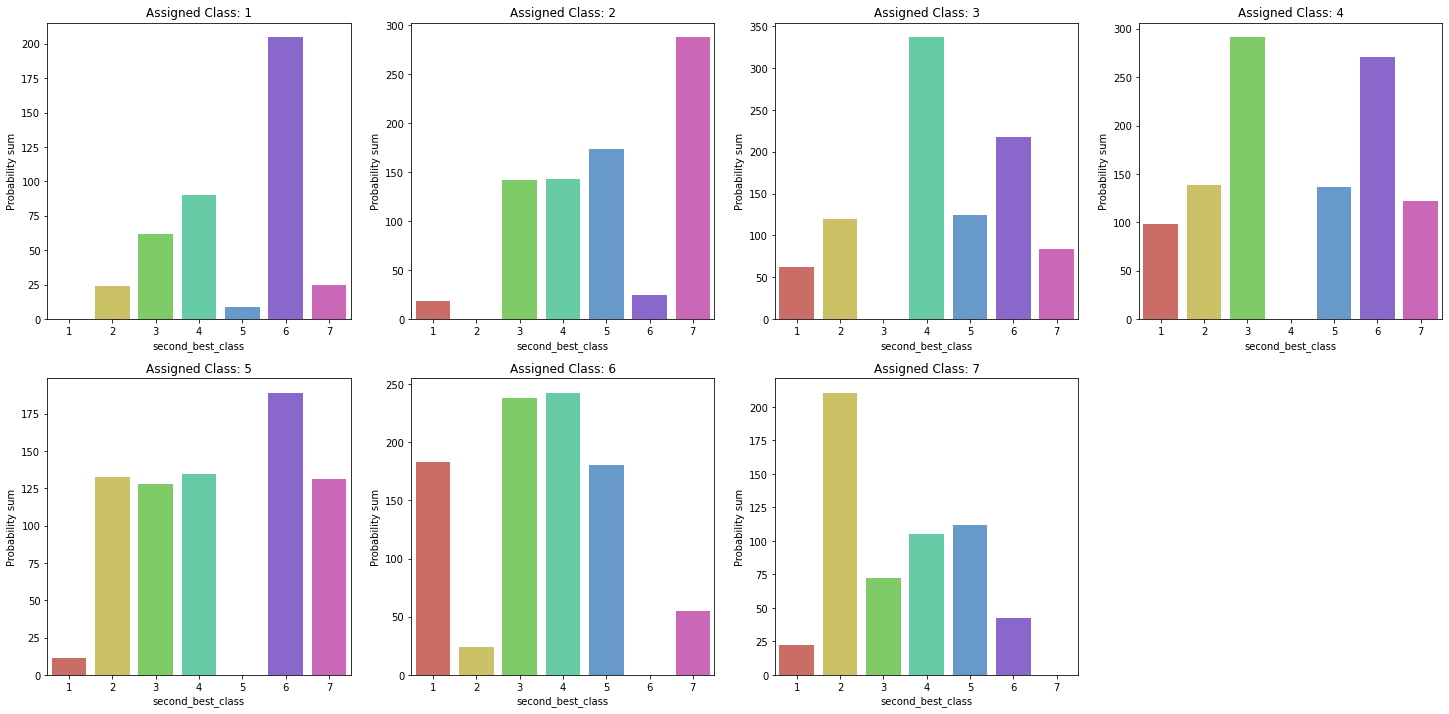

In [144]:
second_highest_probs_sum = predictions_df.groupby(["best_class", "second_best_class"])["second_highest_prob"].sum().reset_index()

plt.subplots(figsize=(15, 5))
format_dataframe = pd.DataFrame({"second_best_class": range(1, 8)})
for i in range(1, 8):
    second_best_match_for_i = second_highest_probs_sum.loc[second_highest_probs_sum["best_class"] == i, ["second_best_class", "second_highest_prob"]]
    
    # We merge so that all classes 1 to 7 are available, we do this to keep colours consistent throughout plots
    plot_df = pd.merge(left=format_dataframe, right=second_best_match_for_i, how="left", on="second_best_class")
    ax = plt.subplot(2, 4, i)
    sns.barplot(data=plot_df, x="second_best_class", y="second_highest_prob", palette=sns.color_palette("hls", 7))
    ax.set_ylabel("Probability sum")
    ax.set_title("Assigned Class: " + str(i))

<AxesSubplot:>

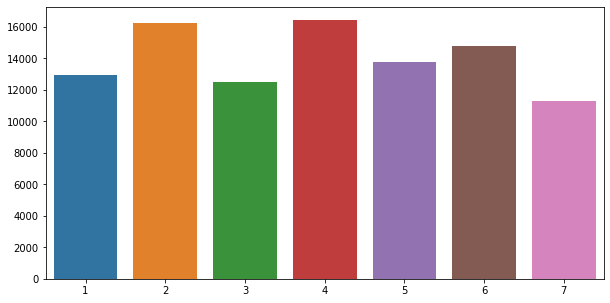

In [145]:
plt.figure(figsize=(10, 5))
val_c = predictions_df["best_class"].value_counts()
sns.barplot(x=val_c.index, y=val_c.values)
plt.show()

# Submission

In [149]:
sample_submission["Predicted"] = predictions_df["best_class"]
sample_submission.to_csv('submission.csv')

# Appendix
## Tune Models Parameters

In [ ]:
import optuna
from functools import partial

KF = KFold(5)
SCORING = {"f1_score": make_scorer(f1_score)}

**Logistic Regression Example**

In [ ]:
def optimize_log_reg(trial, X_, y_):
    C = trial.suggest_float("C", 1.0, 30.0, step=0.1)
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
    max_iter = trial.suggest_int("max_iter", 50, 300)

    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter)
    cv_results = cross_validate(estimator=model, X=x, y=y, cv=KF, scoring=SCORING, n_jobs=-1)
    return cv_results["test_f1_score"].mean()

In [ ]:
study = optuna.create_study(direction="maximize")
log_reg_optimization_fu = partial(optimize_log_reg, X_=X, y_=y)
study.optimize(g_boost_optimization_fu, n_trials=100)
print("Best parameters:", study.best_params)  
print("Best result:", study.best_value) 